### Segmentação Semântica com U-NET

A segmentação semântica e a de instâncias tem sido usada amplamente no setor de Saúde durante a pandemia de COVID-19 para ajudar os médicos a distinguir, entre as imagens de raios-X de vários pulmões, quais exibem pneumonia normal e quais exibem infecção por Coronavirus.

### Importação das bibliotecas

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm # Mostrar barra de progresso
import matplotlib.pyplot as plt
import tensorflow
import keras
import random
tensorflow.__version__

'2.18.0'

In [2]:
# Utilizado para ocultar alguns avisos do tensorflow nas células do notebook na execução que pode prejudicar um pouco a visualização
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Dataset

**Data Science Bowl de 2018** - https://www.kaggle.com/competitions/data-science-bowl-2018

Antes (com os exemplos de segmentação de instâncias) trabalhamos com máscaras em um arquivo json que armazena as posições x e y dos objetos. Com este dataset trabalharemos com uma forma alternativa para armazenar os segmentos, no caso, as máscaras também serão imagens.

In [3]:
os.environ['KAGGLE_USERNAME'] = 'wolfros'
os.environ['KAGGLE_KEY'] = 'c1df133274141a6dea216267d44c22db'

Antes de fazer o download, é necessário baixar o kaggle, criar uma chave de api no kaggle e aceitar os termos da competição.

In [4]:
#!pip install kaggle

Baixando o dataset.

In [5]:
#!kaggle competitions download -c data-science-bowl-2018

Caso não exista pasta 'data', cria uma e descompacta os dados dentro desta pasta.

In [6]:
#!mkdir data && tar -xf data-science-bowl-2018.zip -C data

Verifica em qual diretório está.

In [7]:
#%pwd

Entra na pasta data, cria uma nova pasta 'train' caso não exista e descompata nela os dados de treino.

In [8]:
#%cd data
#!mkdir train && tar -xf stage1_train.zip -C train

Cria uma pasta 'test' caso não exista e descompacta nela os dados de teste.

In [9]:
#!mkdir test && tar -xf stage1_test.zip -C test

Volta para o diretório raiz.

In [10]:
#%cd ..

### Carregamento das imagens

In [11]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

SEED = 42 # Definindo seed para reprodutibilidade de resultados
np.random.seed = SEED
random.seed = SEED

PATH_TRAIN = 'data/train/'
PATH_TEST = 'data/test/'

Os nomes das pastas em cada pasta (train e test) são os mesmos nomes dos arquivos.

In [12]:
# Retorna o próximo valor de uma lista
# 1° elemento retorna o path
# 2° elemento retorna o array de itens (no caso nome das pastas que contem as imagens)
train_ids = next(os.walk(PATH_TRAIN))[1] # Estamos pegando o 2° elemento

# Visualizando os 5 primeiros ids das imagens de treino
for id in range(0,5):
    print(train_ids[id])

00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552
003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1
00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed
01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf


In [13]:
# Fazemos a mesma coisa para os dados de teste
test_ids = next(os.walk(PATH_TEST))[1]

In [14]:
print(f'{len(train_ids)} para treinamento \n {len(test_ids)} para teste.')

670 para treinamento 
 65 para teste.


A máscara da imagem é composta somente pelo pixel 0 (zero) que representa o fundo e pelo pixel 1 (no caso, será 255 após ser multiplicado por 255) que representa onde está o objeto, na cor branca.

In [15]:
# Criando um array composto de zeros onde:
#                       qtd de imagens   altura     largura    canais (rgb)
dataset_img = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Fazemos a mesma coisa para as máscaras, porém com apenas 1 canal e o tipo de dados booleano (0 e 1)
dataset_mask = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

dataset_img.shape, dataset_mask.shape # A única diferença é o número de canais

((670, 256, 256, 3), (670, 256, 256, 1))

### Pré-processamento dos dados

O *tqdm* gera uma barra de progresso.

**Iremos unir todas as máscaras em uma única imagem**, assim como, redimensionar as imagens em uma dimensão padrão (256x256 pixels).

Pré processamento dos dados de **treinamento**.

In [16]:
# Percorre todas as imagens de treino
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = PATH_TRAIN + id_ # Path de cada imagem

    if '.' in path: # Ignorando arquivos .ipynb_checkpoints gerado pelo notebook
        continue

    img = cv2.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] # Seleciona apenas os 3 primeiros canais da imagem
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # Todas as imagens devem ficar em uma resolução padrão (no caso, 256x256)
    dataset_img[n] = img

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    # Percorre cada uma das imagens na pasta masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = cv2.imread(path + '/masks/' + mask_file)
        mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY) # Converte para escala de cinza
        mask_ = np.expand_dims(cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH)), axis=-1) # axis=-1 para adicionarmos mais uma dimensão no final do vetor

        # Atualiza a variável mask com a nova máscara do loop na variável mask_
        # No final, as máscaras serão concatenadas em uma só imagem
        mask = np.maximum(mask, mask_)
    
    dataset_mask[n] = mask
        

100%|██████████| 670/670 [00:54<00:00, 12.22it/s]


((256, 256, 3), (256, 256))

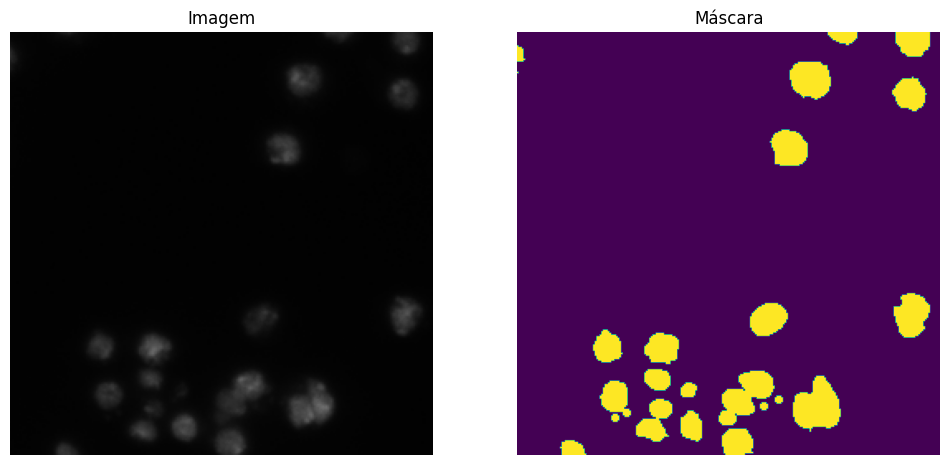

In [17]:
id_img = 0
fig = plt.figure(figsize=(12,6))

fig.add_subplot(1,2,1) # 1 linha, 2 colunas, índice 1
plt.imshow(dataset_img[id_img])
plt.axis('off')
plt.title('Imagem')

fig.add_subplot(1,2,2)
plt.imshow(np.squeeze(dataset_mask[id_img])) # squeeze para remover a terceira dimensão, remove o canal 1, ficando apenas (256,256)
plt.axis('off')
plt.title('Máscara')

dataset_img[id_img].shape, np.squeeze(dataset_mask[id_img]).shape

Pré processamento dos dados de **teste**.

In [18]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [19]:
# Percorre todas as imagens de teste
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = PATH_TEST + id_ # Path de cada imagem

    if '.' in path: # Ignorando arquivos .ipynb_checkpoints gerado pelo notebook
        continue

    img = cv2.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] # Seleciona apenas os 3 primeiros canais da imagem
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # Todas as imagens devem ficar em uma resolução padrão (no caso, 256x256)
    X_test[n] = img

print(X_test.shape)

100%|██████████| 65/65 [00:00<00:00, 229.68it/s]

(65, 256, 256, 3)


**Separação dos dados em treino e validação.**

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dataset_img, dataset_mask,
                                                  test_size=0.2,
                                                  random_state=SEED)

In [21]:
X_train.shape

(536, 256, 256, 3)

In [22]:
X_val.shape

(134, 256, 256, 3)

In [23]:
y_train.shape

(536, 256, 256, 1)

In [24]:
y_val.shape

(134, 256, 256, 1)

### Construção da Rede Neural

Input -> Camada de entrada da rede neural.

Conv2D -> Camada convolucional.

MaxPooling2D -> Camada de redução de dimensionalidade.

UpSampling2D -> Camada para aumentar a dimensionalidade.

concatenate -> Para concatenar as camadas.

BatchNormalization -> Técnica para normalizar os valores de cada camada.

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import keras

#### Convolução

Para conectar uma camada na outra, basta no final da camada colocar entre parenteses o valor anterior (input ou x).

O parâmetro *padding='same'* serve para manter todos os pixels da imagem, sem perder informação.

O Conv2D irá percorrer a matriz da imagem a partir de uma janela deslizante de 3x3 pixels.

Função para facilitar o processo de convolução.

In [26]:
def bloco_conv(input, num_filters):
    x = keras.layers.Conv2D(num_filters, 3, padding='same')(input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    return x

#### Encoder

Basicamente, é o bloco de convolução seguido pelo **MaxPooling** para a redução de dimensionalidade.

In [27]:
def bloco_encoder(input, num_filters):
    x = bloco_conv(input, num_filters)
    p = keras.layers.MaxPool2D((2,2))(x)

    return x, p

#### Decoder

O skip_features é para fazer a cópia e concatenação.

O **Conv2DTranspose** serve para aumentar a dimensionalidade.

O parâmetro *strides* do Conv2DTranspose é a quantidade de pixels que a janela deslizante deve se mover para percorrer a matriz.

**Concatenação**
- Antes de enviar todos os dados para as camadas de baixo, é enviado uma cópia do resultado dessas camadas de convolução diretamente para a camada final.
- É realizado a cópia e concatenação.

In [28]:
def bloco_decoder(input, skip_features, num_filters):
    x = keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
    x = keras.layers.Concatenate()([x, skip_features])
    x = bloco_conv(x, num_filters)

    return x

#### Modelo final

Precisamos retornar se um determinado pixel é o fundo da imagem ou o objeto, para isto, utilizamos a **função de ativação *sigmoid***. Está função retornará uma probabilidade, um número entre 0 e 1.

In [29]:
def modelo_unet(input_shape) -> keras.models.Model:
    inputs = keras.layers.Input(input_shape)

    # Blocos Encoder
    s1, p1 = bloco_encoder(inputs, 64)
    s2, p2 = bloco_encoder(p1, 128)
    s3, p3 = bloco_encoder(p2, 256)
    s4, p4 = bloco_encoder(p3, 512)

    b1 = bloco_conv(p4, 1024)

    # Blocos Decoder
    d1 = bloco_decoder(b1, s4, 512) # Realiza a concatenação com o s4, e em sequência, com s3, s2 e s1
    d2 = bloco_decoder(d1, s3, 256)
    d3 = bloco_decoder(d2, s2, 128)
    d4 = bloco_decoder(d3, s1, 64)

    outputs = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = keras.models.Model(inputs, outputs, name='UNet') # Liga a entrada com a saída
    return model

In [30]:
model = modelo_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

In [31]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), # learning_rate = 0.00001
              loss=keras.losses.BinaryCrossentropy(), # Será um modelo de classificação binária (classificará fundo ou objeto)
              metrics=['accuracy'])
model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

**Salvar o modelo em json**

In [32]:
model_file = 'modelo_unet.json'
model_file_json = model.to_json()
with open(model_file, 'w') as json_file:
    json_file.write(model_file_json)

#### Callbacks

Callbacks para salvar a rede neural durante o treinamento.

*Patience:* É usado para tolerar quando o modelo não melhore o desempenho após a quantidade de épocas especificadas, onde caso o valor de perda não diminuir, irá finalizar o treinamento. 

In [33]:
filename_model = 'modelo_unet.keras'
checkpointer = keras.callbacks.ModelCheckpoint(filename_model,
                                               monitor='val_loss',
                                               verbose=1,
                                               save_best_only=True)
early_stopper = keras.callbacks.EarlyStopping(patience=5, # Iremos tolerar que o modelo não melhore o seu desempenho depois de 5 épocas
                                              monitor='val_loss')

callbacks = [checkpointer, early_stopper]

### Treinamento

**Batch_size** -> De quantas em quantas imagens iremos enviar para a rede neural para realizar o ajuste dos pesos. Já que estamos lidando com uma base de dados pequena de 600 imagens, podemos utilizar um valor de batch_size pequeno.

In [34]:
EPOCHS = 15
BATCH_SIZE = 8

Ao final de cada época, os dados de validação serão enviados para a rede neural para ser realizado uma previsão, com isso, conseguimos verificar o desempenho da rede neural durante o treinamento.

In [35]:
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/15
 7/67 ━━━━━━━━━━━━━━━━━━━━ 10:28 10s/step - accuracy: 0.7467 - loss: 0.6344

KeyboardInterrupt: 

**OBS. Foi necessário continuar o treinamento pelo Google Colab, por conta disso, foi criado um novo notebook chamado *introducao_unet_colab.ipynb* com o treinamento da rede neural.** 